In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
import os
os.chdir('/content/drive/MyDrive/Final Year Project')

Mounted at /content/drive


In [ ]:
import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Conv2D, MaxPool2D , Flatten, Input
from keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing import image
from keras.applications.vgg16 import VGG16
import numpy as np
import csv

In [ ]:
new_vgg = np.loadtxt('Image Classifier/vgg_train_data.csv')
new_vgg.shape

(642, 25088)

In [ ]:
vgg_model = VGG16(include_top=False)

58900480/58889256 [==============================] - 0s 0us/step


In [ ]:
import json

train_data = []
test_data = []
valid_data = []

with open("Slake1.0/train.json", "r") as fp:
  train_data = json.load(fp)
with open("Slake1.0/test.json", "r") as fp:
  test_data = json.load(fp)
with open("Slake1.0/validate.json", "r") as fp:
  valid_data = json.load(fp)

data1 = []

for item in train_data:
    if item['q_lang'] == 'en' and item['base_type'] == 'vqa':
        data1.append(item)

train_data = data1


data2 = []
for item in test_data:
    if item['q_lang'] == 'en' and item['base_type'] == 'vqa':
        data2.append(item)

test_data = data2

data3 = []
for item in valid_data:
    if item['q_lang'] == 'en' and item['base_type'] == 'vqa':
        data3.append(item)
valid_data = data3

In [ ]:
train_questions = []

for item in train_data:
    train_questions.append(item['question'])

In [ ]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Embedding

t = Tokenizer()
t.fit_on_texts(train_questions)
vocab_size = len(t.word_index) + 1
print(t.word_index)

maxlen=16

def obtain_padded_questions(questions, maxlen, t):
    encoded = t.texts_to_sequences(questions)

    padded = pad_sequences(encoded, padding='post', maxlen=maxlen)
    padded = np.array(padded)

    return padded

embeddings_index = dict()

f = open('Question Classifier/glove.6B.100d.txt')
for line in f:
	values = line.split()
	word = values[0]
	coefs = np.asarray(values[1:], dtype='float32')
	embeddings_index[word] = coefs
f.close()

print('Loaded %s word vectors.' % len(embeddings_index))

# create a weight matrix for words in training docs
embedding_matrix = np.zeros((vocab_size, 100))
for word, i in t.word_index.items():
  embedding_vector = embeddings_index.get(word)
  if word.endswith("'s"):
    embedding_vector = embeddings_index.get(word[:-2])
  if embedding_vector is not None:
    embedding_matrix[i] = embedding_vector
  else:
    print(word)

{'the': 1, 'is': 2, 'this': 3, 'image': 4, 'in': 5, 'what': 6, 'picture': 7, 'does': 8, 'of': 9, 'organ': 10, 'which': 11, 'contain': 12, 'are': 13, 'to': 14, 'lung': 15, 'part': 16, 'body': 17, 'where': 18, 'liver': 19, 'modality': 20, 'belong': 21, 'or': 22, 'plane': 23, 'used': 24, 'how': 25, 'on': 26, 'take': 27, 'heart': 28, 'many': 29, 'located': 30, 'there': 31, 'largest': 32, 'left': 33, 'a': 34, 'abnormal': 35, 'kidney': 36, 'abnormality': 37, 'spleen': 38, 'diseases': 39, 'included': 40, 'system': 41, 'right': 42, 'organs': 43, 'healthy': 44, 'abnormalities': 45, 'shown': 46, 'brain': 47, 'color': 48, 'scanning': 49, 'look': 50, 'show': 51, 'kidneys': 52, 'weighting': 53, 'normal': 54, 'do': 55, 'mri': 56, 'mr': 57, 'bigger': 58, 'study': 59, 'exist': 60, 'main': 61, 'can': 62, 'be': 63, 'observed': 64, 'appear': 65, 'top': 66, 'taken': 67, 'transverse': 68, 'lower': 69, 'head': 70, 'black': 71, 'lungs': 72, 'scanned': 73, 'side': 74, 'coronal': 75, 'chest': 76, 'an': 77, 'ct

In [ ]:
x_train = []
y_train = []

for item in train_data:

    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    
    if " or " in item['question'] or "," in item['answer']:
        continue
    
    x_train.append(item['question'])
    
    if item['answer_type'] == 'CLOSED':
        y_train.append(0)
    else:
        y_train.append(1)

x_test = []
y_test = []

for item in test_data:

    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    
    if " or " in item['question'] or "," in item['answer']:
        continue
    
    x_test.append(item['question'])
    
    if item['answer_type'] == 'CLOSED':
        y_test.append(0)
    else:
        y_test.append(1)

x_valid = []
y_valid = []

for item in valid_data:

    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    
    if " or " in item['question'] or "," in item['answer']:
        continue
    
    x_valid.append(item['question'])
    
    if item['answer_type'] == 'CLOSED':
        y_valid.append(0)
    else:
        y_valid.append(1)

In [ ]:
from keras.layers import Bidirectional, LSTM, Dropout

model_ques = Sequential([
    Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False),
    Bidirectional(LSTM(units=50, return_sequences=True)),
    Dropout(0.2),
    Flatten(),
    Dense(units=1, activation='sigmoid')
])

model_ques.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
x_train = obtain_padded_questions(x_train, maxlen, t)
y_train = np.array(y_train)

x_test = obtain_padded_questions(x_test, maxlen, t)
y_test = np.array(y_test)

x_valid = obtain_padded_questions(x_valid, maxlen, t)
y_valid = np.array(y_valid)

model_ques.fit(x_train, y_train, epochs=10, validation_data=(x_valid, y_valid))

Epoch 1/10
124/124 [==============================] - 8s 26ms/step - loss: 0.1406 - accuracy: 0.9344 - val_loss: 3.4173e-04 - val_accuracy: 1.0000
Epoch 2/10
124/124 [==============================] - 2s 18ms/step - loss: 0.0132 - accuracy: 0.9962 - val_loss: 4.7764e-04 - val_accuracy: 1.0000
Epoch 3/10
124/124 [==============================] - 2s 18ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 2.1184e-04 - val_accuracy: 1.0000
Epoch 4/10
124/124 [==============================] - 2s 17ms/step - loss: 0.0025 - accuracy: 0.9997 - val_loss: 2.3384e-04 - val_accuracy: 1.0000
Epoch 5/10
124/124 [==============================] - 2s 18ms/step - loss: 0.0024 - accuracy: 0.9997 - val_loss: 2.6366e-04 - val_accuracy: 1.0000
Epoch 6/10
124/124 [==============================] - 2s 18ms/step - loss: 0.0023 - accuracy: 0.9997 - val_loss: 2.7244e-04 - val_accuracy: 1.0000
Epoch 7/10
124/124 [==============================] - 2s 18ms/step - loss: 0.0022 - accuracy: 0.9997 - val_loss: 2.118

In [ ]:
model_ques.evaluate(x_test, y_test)

26/26 [==============================] - 0s 6ms/step - loss: 1.7992e-04 - accuracy: 1.0000


[0.00017991552886087447, 1.0]

In [ ]:
c = ["What is the modality that this image is taken in?", "What is the main organ is this image?", "Is this a CT?", "Is this an MRI?", "Does this image contain lung?"]
d = [1, 1, 0, 0, 0]

c2 = obtain_padded_questions(c, maxlen, t)
for i in range(len(c2)):
    print(c[i])
    in_c = np.expand_dims(c2[i], axis=0)
    pred_model_ques = model_ques.predict(in_c)
    if(pred_model_ques > 0.5):
        print("Open")
    else:
        print("Closed")
    print()

What is the modality that this image is taken in?
Open

What is the main organ is this image?
Open

Is this a CT?
Closed

Is this an MRI?
Closed

Does this image contain lung?
Closed



In [ ]:
closed_answers = {"No":0, "Yes":1}
open_answers = {}

i=0
for item in train_data + test_data + valid_data:
    
    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    
    if " or " in item['question'] or "," in item['answer']:
        continue

    answer = item['answer']
    if item['answer'] == "Noudle":
        answer = "Nodule"
    if item['answer'] == "Brian":
        answer = "Brain"
    if item['answer'] == "Transverse  Plane":
        answer = "Transverse Plane"
    
    if answer not in ("Yes", "No"):
        if answer not in open_answers:
            open_answers[answer] = i
            i+=1

In [ ]:
import json

f = open("Slake1.0/test.json", "r")
a = json.load(f)

b = []
for item in a:
    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    if " or " in item['question'] or "," in item['answer']:
        continue

    b.append(item)

len(b)

831

In [ ]:
x_train_open = []
x_train_closed = []
y_train_open = []
y_train_closed = []

x_train_open_images = []
x_train_closed_images = []

for item in train_data:

    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    
    if " or " in item['question'] or "," in item['answer']:
        continue
    
    if item['answer_type'] == 'CLOSED':
        x_train_closed.append(item['question'])
        x_train_closed_images.append(item['img_id'])
        y_train_closed.append(closed_answers[item['answer']])
    
    else:

        answer = item['answer']
        if item['answer'] == "Noudle":
            answer = "Nodule"
        if item['answer'] == "Brian":
            answer = "Brain"
        if item['answer'] == "Transverse  Plane":
            answer = "Transverse Plane"

        x_train_open.append(item['question'])
        x_train_open_images.append(item['img_id'])
        y_train_open.append(open_answers[answer])

x_valid_open = []
x_valid_closed = []
y_valid_open = []
y_valid_closed = []

x_valid_open_images = []
x_valid_closed_images = []

for item in valid_data:

    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    
    if " or " in item['question'] or "," in item['answer']:
        continue
    
    if item['answer_type'] == 'CLOSED':
        x_valid_closed.append(item['question'])
        x_valid_closed_images.append(item['img_id'])
        y_valid_closed.append(closed_answers[item['answer']])
    
    else:

        answer = item['answer']
        if item['answer'] == "Noudle":
            answer = "Nodule"
        if item['answer'] == "Brian":
            answer = "Brain"
        if item['answer'] == "Transverse  Plane":
            answer = "Transverse Plane"

        x_valid_open.append(item['question'])
        x_valid_open_images.append(item['img_id'])
        y_valid_open.append(open_answers[answer])

x_test_open = []
x_test_closed = []
y_test_open = []
y_test_closed = []

x_test_open_images = []
x_test_closed_images = []

for item in test_data:

    if item['q_lang'] == 'zh' or item['base_type'] == 'kvqa':
        continue
    
    if " or " in item['question'] or "," in item['answer']:
        continue
    
    if item['answer_type'] == 'CLOSED':
        x_test_closed.append(item['question'])
        x_test_closed_images.append(item['img_id'])
        y_test_closed.append(closed_answers[item['answer']])
    
    else:

        answer = item['answer']
        if item['answer'] == "Noudle":
            answer = "Nodule"
        if item['answer'] == "Brian":
            answer = "Brain"
        if item['answer'] == "Transverse  Plane":
            answer = "Transverse Plane"

        x_test_open.append(item['question'])
        x_test_open_images.append(item['img_id'])
        y_test_open.append(open_answers[answer])

In [ ]:
x_train_open = obtain_padded_questions(x_train_open, maxlen, t)
x_train_closed = obtain_padded_questions(x_train_closed, maxlen, t)

x_train_open = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(x_train_open)
x_train_closed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(x_train_closed)

x_train_open = Flatten()(x_train_open)
x_train_closed = Flatten()(x_train_closed)

x_valid_open = obtain_padded_questions(x_valid_open, maxlen, t)
x_valid_closed = obtain_padded_questions(x_valid_closed, maxlen, t)

x_valid_open = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(x_valid_open)
x_valid_closed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(x_valid_closed)

x_valid_open = Flatten()(x_valid_open)
x_valid_closed = Flatten()(x_valid_closed)

x_test_open = obtain_padded_questions(x_test_open, maxlen, t)
x_test_closed = obtain_padded_questions(x_test_closed, maxlen, t)

x_test_open = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(x_test_open)
x_test_closed = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(x_test_closed)

x_test_open = Flatten()(x_test_open)
x_test_closed = Flatten()(x_test_closed)

In [ ]:
x_train_open = x_train_open.numpy()
x_train_closed = x_train_closed.numpy()

x_valid_open = x_valid_open.numpy()
x_valid_closed = x_valid_closed.numpy()

x_test_open = x_test_open.numpy()
x_test_closed = x_test_closed.numpy()

In [ ]:
from tensorflow.keras.utils import to_categorical

y_train_open = to_categorical(y_train_open, len(open_answers))
y_train_closed = np.array(y_train_closed)

y_valid_open = to_categorical(y_valid_open, len(open_answers))
y_valid_closed = np.array(y_valid_closed)

y_test_open = to_categorical(y_test_open, len(open_answers))
y_test_closed = np.array(y_test_closed)

In [ ]:
len(x_test_open_images)

515

In [ ]:
open_fused_train = []
closed_fused_train = []

for i in range(len(x_train_open_images)):
    img_vector = new_vgg[x_train_open_images[i]]

    ques_vector = x_train_open[i]
    
    open_fused_train.append(np.concatenate((img_vector, ques_vector)))

for i in range(len(x_train_closed_images)):
    img_vector = new_vgg[x_train_closed_images[i]]

    ques_vector = x_train_closed[i]
    
    closed_fused_train.append(np.concatenate((img_vector, ques_vector)))

open_fused_valid = []
closed_fused_valid = []

for i in range(len(x_valid_open_images)):
    img_vector = new_vgg[x_valid_open_images[i]]

    ques_vector = x_valid_open[i]
    
    open_fused_valid.append(np.concatenate((img_vector, ques_vector)))

for i in range(len(x_valid_closed_images)):
    img_vector = new_vgg[x_valid_closed_images[i]]

    ques_vector = x_valid_closed[i]
    
    closed_fused_valid.append(np.concatenate((img_vector, ques_vector)))

open_fused_test = []
closed_fused_test = []

for i in range(len(x_test_open_images)):
    img_vector = new_vgg[x_test_open_images[i]]

    ques_vector = x_test_open[i]
    
    open_fused_test.append(np.concatenate((img_vector, ques_vector)))

for i in range(len(x_test_closed_images)):
    img_vector = new_vgg[x_test_closed_images[i]]

    ques_vector = x_test_closed[i]
    
    closed_fused_test.append(np.concatenate((img_vector, ques_vector)))

In [ ]:
open_fused_train = np.array(open_fused_train)
closed_fused_train = np.array(closed_fused_train)

open_fused_valid = np.array(open_fused_valid)
closed_fused_valid =np.array(closed_fused_valid)

open_fused_test = np.array(open_fused_test)
closed_fused_test = np.array(closed_fused_test)

In [ ]:
len(open_answers)

124

In [ ]:
open_classifier = Sequential([
        Input(shape=(26688,)),
        Dense(units=len(open_answers), activation='softmax')
])

open_classifier.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
open_classifier.fit(open_fused_train, y_train_open, epochs=100, validation_data=(open_fused_valid, y_valid_open))

In [ ]:
len(open_fused_test)

515

In [ ]:
open_classifier.evaluate(open_fused_test, y_test_open)

17/17 [==============================] - 0s 10ms/step - loss: 71.4257 - accuracy: 0.6291


[71.42571258544922, 0.6291261911392212]

In [ ]:
len(closed_fused_test)

316

In [ ]:
closed_classifier = Sequential([
        Input(shape=(26688,)),
        Dense(units=1, activation='sigmoid')
])

closed_classifier.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

closed_classifier.fit(closed_fused_train, y_train_closed, epochs=100, validation_data=(closed_fused_valid, y_valid_closed))

Epoch 1/100
48/48 [==============================] - 1s 10ms/step - loss: 9.2422 - accuracy: 0.5000 - val_loss: 6.7159 - val_accuracy: 0.5431
Epoch 2/100
48/48 [==============================] - 0s 6ms/step - loss: 6.6276 - accuracy: 0.5609 - val_loss: 4.8786 - val_accuracy: 0.5463
Epoch 3/100
48/48 [==============================] - 0s 6ms/step - loss: 5.6824 - accuracy: 0.5682 - val_loss: 6.5005 - val_accuracy: 0.5399
Epoch 4/100
48/48 [==============================] - 0s 5ms/step - loss: 5.8501 - accuracy: 0.5808 - val_loss: 5.6860 - val_accuracy: 0.5815
Epoch 5/100
48/48 [==============================] - 0s 5ms/step - loss: 6.8463 - accuracy: 0.5808 - val_loss: 5.0971 - val_accuracy: 0.5304
Epoch 6/100
48/48 [==============================] - 0s 6ms/step - loss: 6.7064 - accuracy: 0.5828 - val_loss: 4.7246 - val_accuracy: 0.5559
Epoch 7/100
48/48 [==============================] - 0s 6ms/step - loss: 6.2670 - accuracy: 0.5901 - val_loss: 5.9503 - val_accuracy: 0.5591
Epoch 8/100


In [ ]:
closed_classifier.evaluate(closed_fused_test, y_test_closed)

10/10 [==============================] - 0s 4ms/step - loss: 7.0446 - accuracy: 0.6108


[7.0445756912231445, 0.6107594966888428]

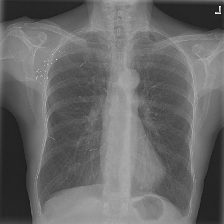

What diseases are in this image?
Lung


In [ ]:
from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt

question = ["What diseases are in this image?"]
padded = obtain_padded_questions(question, maxlen, t)

prediction = model_ques.predict(padded)

img = image.load_img(f"Slake1.0/imgs/xmlab144/source.jpg", target_size=(224, 224))
img = image.img_to_array(img)
cv2_imshow(img)

print(question[0])

img = new_vgg[144]

if prediction > 0.5:
    padded = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(padded)
    padded = Flatten()(padded)

    padded = np.squeeze(padded)

    fused = np.concatenate((img, padded))

    fused = np.reshape(fused, (1, 26688))

    answers = np.argmax(open_classifier.predict(fused))

    final_answer = ""

    for answer in open_answers:
        if open_answers[answer] == answers:
            print(answer)
            break

else:
    padded = Embedding(vocab_size, 100, weights=[embedding_matrix], input_length=16, trainable=False)(padded)
    padded = Flatten()(padded)

    padded = np.squeeze(padded)

    fused = np.concatenate((img, padded))

    fused = np.reshape(fused, (1, 26688))

    answers = closed_classifier.predict(fused)

    if answers > 0.5:
        print("Yes")
    else:
        print("No")
    print("")